# MNIST Model Training and Evaluation

This notebook implements the CNN model, training pipeline, and evaluation for the MNIST dataset classification task. We'll cover:

1. Model Architecture 
2. Training Configuration
3. Training Loop Implementation
4. Model Evaluation
5. Results Visualization

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

Device in use: cuda


## 1. Model Architecture

We'll implement a Convolutional Neural Network (CNN) for MNIST classification:

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # First Convolutional Block
        self.conv1 = nn.Conv2d(
            in_channels=1,       # Number of input channels (1 for grayscale images)
            out_channels=32,     # Number of filters (32 feature maps as output)
            kernel_size=3,       # Filter size (3x3)
            padding=1            # Padding added to preserve spatial dimensions
        )
        self.bn1 = nn.BatchNorm2d(
            num_features=32      # Normalization applied to 32 feature maps
        )
        self.pool1 = nn.MaxPool2d(
            kernel_size=2        # Size reduction by a factor of 2 (2x2 max pooling)
        )

        # Second Convolutional Block
        self.conv2 = nn.Conv2d(
            in_channels=32,      # Number of input channels (32 from previous block)
            out_channels=64,     # Number of filters (64 feature maps as output)
            kernel_size=3,       # Filter size (3x3)
            padding=1            # Padding added to preserve spatial dimensions
        )
        self.bn2 = nn.BatchNorm2d(
            num_features=64      # Normalization applied to 64 feature maps
        )
        self.pool2 = nn.MaxPool2d(
            kernel_size=2        # Size reduction by a factor of 2 (2x2 max pooling)
        )

        # Third Convolutional Block
        self.conv3 = nn.Conv2d(
            in_channels=64,      # Number of input channels (64 from previous block)
            out_channels=128,    # Number of filters (128 feature maps as output)
            kernel_size=3,       # Filter size (3x3)
            padding=1            # Padding added to preserve spatial dimensions
        )
        self.bn3 = nn.BatchNorm2d(
            num_features=128     # Normalization applied to 128 feature maps
        )
        self.pool3 = nn.MaxPool2d(
            kernel_size=2        # Size reduction by a factor of 2 (2x2 max pooling)
        )

        # Fully Connected Layers
        self.fc1 = nn.Linear(
            in_features=128 * 3 * 3, # Input size (flattened after convolutions)
            out_features=512         # Number of neurons in hidden layer
        )
        self.dropout = nn.Dropout(
            p=0.5             # Probability to disable a neuron to prevent overfitting
        )
        self.fc2 = nn.Linear(
            in_features=512,       # Input size (from previous layer)
            out_features=10        # Number of output classes (10-class classification)
        )

    def forward(self, x):
        # First block
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))

        # Second block
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        # Third block
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # Flatten
        x = x.view(-1, 128 * 3 * 3)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


## 2. Training Configuration

Define hyperparameters and training settings:

In [5]:
# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(torchvision.datasets.MNIST(root='./data', train=False, transform=transform), batch_size=BATCH_SIZE)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.01MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 3. Training Loop Implementation

In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%\n')

    return train_losses, val_losses, train_accuracies, val_accuracies

# Initialize model, criterion, and optimizer
model = CNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE
)

Epoch [1/10]
Train Loss: 0.1627, Train Accuracy: 95.08%
Val Loss: 0.0587, Val Accuracy: 98.08%

Epoch [2/10]
Train Loss: 0.0572, Train Accuracy: 98.24%
Val Loss: 0.0396, Val Accuracy: 98.77%

Epoch [3/10]
Train Loss: 0.0415, Train Accuracy: 98.72%
Val Loss: 0.0375, Val Accuracy: 98.90%

Epoch [4/10]
Train Loss: 0.0329, Train Accuracy: 99.02%
Val Loss: 0.0316, Val Accuracy: 98.95%

Epoch [5/10]
Train Loss: 0.0280, Train Accuracy: 99.11%
Val Loss: 0.0278, Val Accuracy: 99.14%

Epoch [6/10]
Train Loss: 0.0228, Train Accuracy: 99.26%
Val Loss: 0.0236, Val Accuracy: 99.19%

Epoch [7/10]
Train Loss: 0.0191, Train Accuracy: 99.42%
Val Loss: 0.0279, Val Accuracy: 99.08%

Epoch [8/10]
Train Loss: 0.0174, Train Accuracy: 99.45%
Val Loss: 0.0442, Val Accuracy: 98.73%

Epoch [9/10]
Train Loss: 0.0150, Train Accuracy: 99.53%
Val Loss: 0.0249, Val Accuracy: 99.30%

Epoch [10/10]
Train Loss: 0.0139, Train Accuracy: 99.58%
Val Loss: 0.0303, Val Accuracy: 99.20%



In [ ]:
# save trained model
def save_model(model, path='/content/mnist_model.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")
save_model(model)

## 4. Model Evaluation

In [9]:
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    return all_preds, all_labels

predictions, true_labels = evaluate_model(model, test_loader, DEVICE)

Test Accuracy: 99.28%


## 5. Results Visualization

In [10]:
def plot_training_loss(train_losses, val_losses):
    """Plot training and validation loss over epochs."""
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_training_accuracy(train_accuracies, val_accuracies):
    """Plot training and validation accuracy over epochs."""
    plt.figure(figsize=(10, 6))
    plt.plot(train_accuracies, label='Training Accuracy', color='green')
    plt.plot(val_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(true_labels, predictions):
    """Plot the confusion matrix."""
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


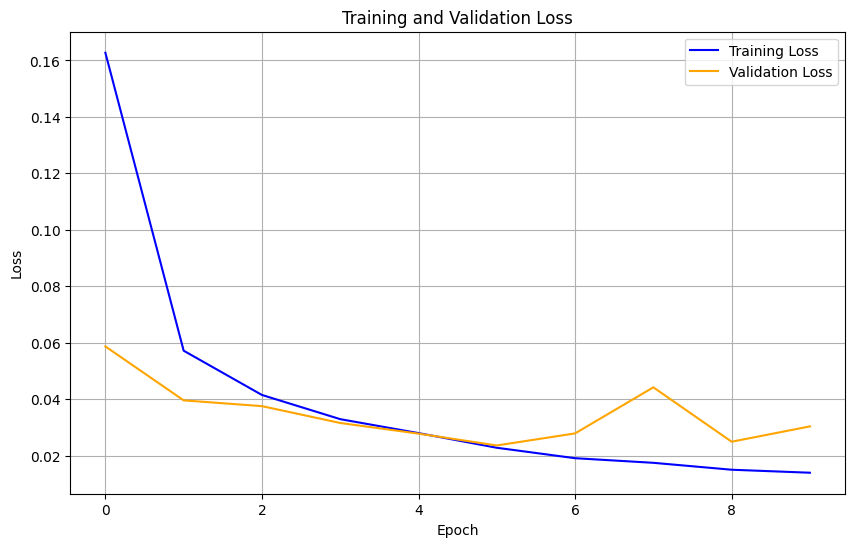

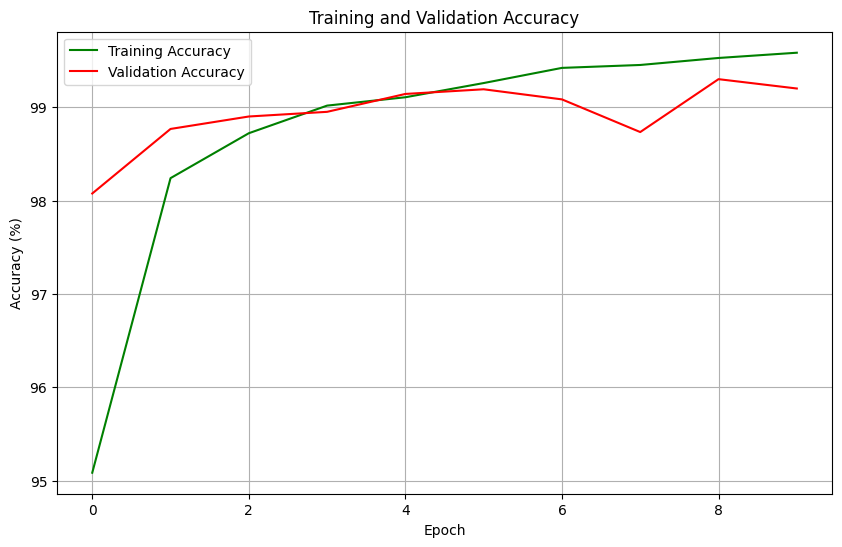

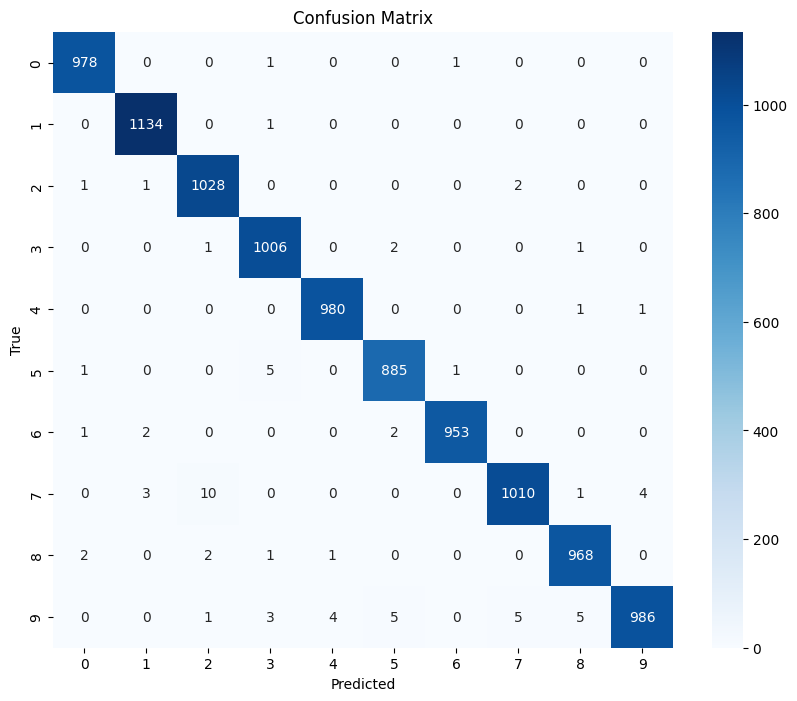

In [11]:
# Plot training loss and validation loss
plot_training_loss(train_losses, val_losses)

# Plot training and validation accuracy
plot_training_accuracy(train_accuracies, val_accuracies)

# Plot confusion matrix
plot_confusion_matrix(true_labels, predictions)

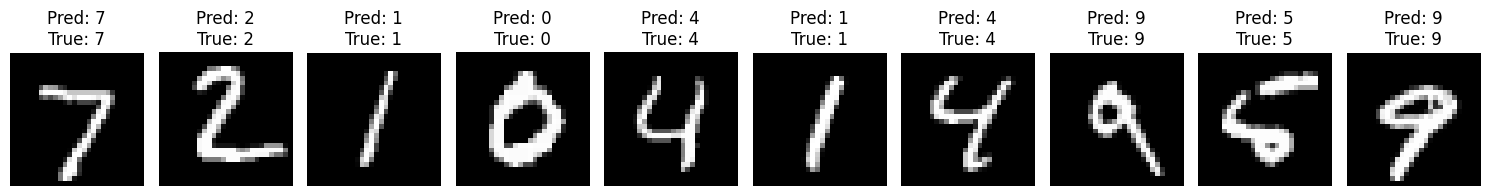

In [12]:
def visualize_predictions(model, test_loader, device, num_samples=10):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images[:num_samples].to(device), labels[:num_samples].to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    fig = plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].cpu().squeeze(), cmap='gray')
        plt.title(f'Pred: {predicted[i]}\nTrue: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_loader, DEVICE)

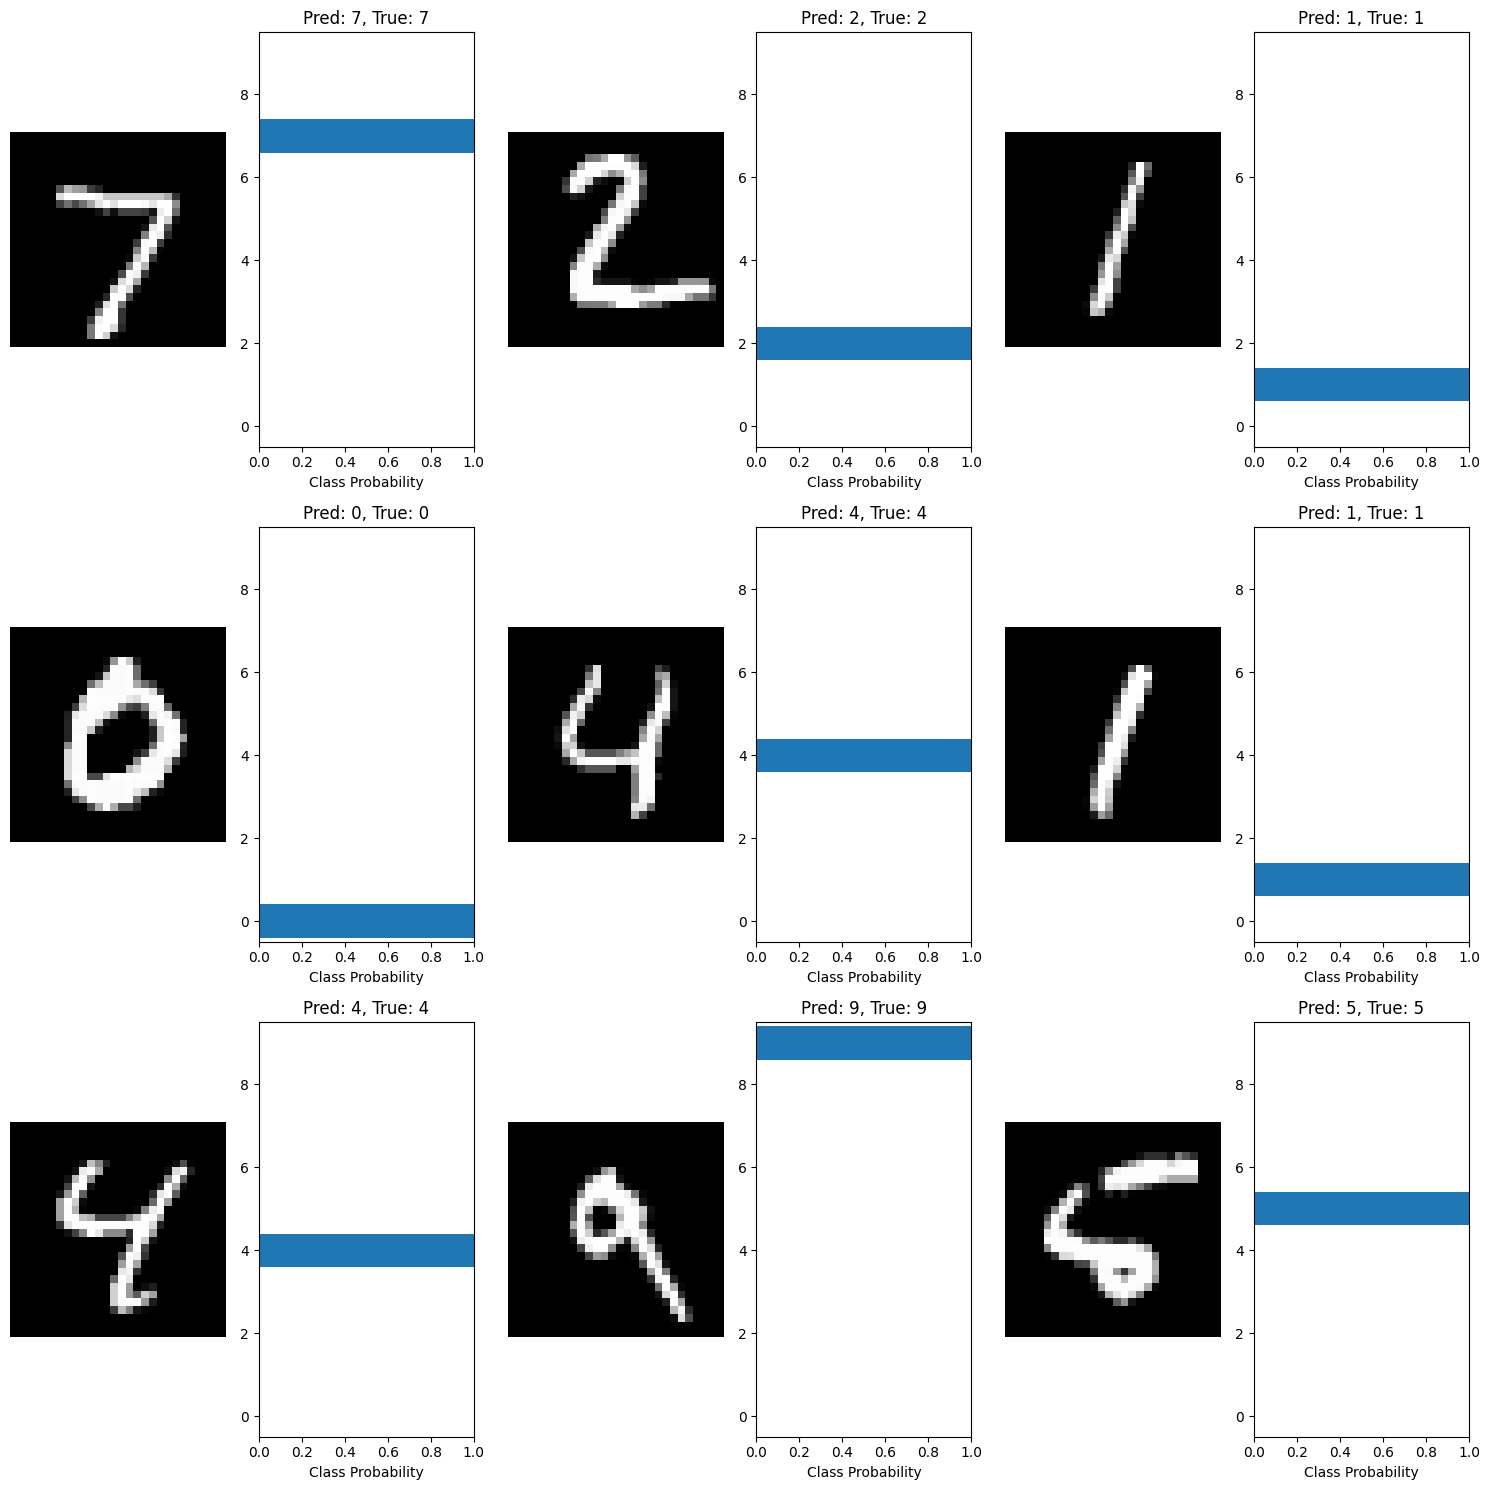


Detailed Analysis of Predictions:

Digit 1:
True Label: 7
Predicted Label: 7
Confidence: 100.00%
Top-3 Predictions:
  Class 7: 100.00%
  Class 4: 0.00%
  Class 9: 0.00%

Digit 2:
True Label: 2
Predicted Label: 2
Confidence: 100.00%
Top-3 Predictions:
  Class 2: 100.00%
  Class 1: 0.00%
  Class 3: 0.00%

Digit 3:
True Label: 1
Predicted Label: 1
Confidence: 100.00%
Top-3 Predictions:
  Class 1: 100.00%
  Class 7: 0.00%
  Class 4: 0.00%

Digit 4:
True Label: 0
Predicted Label: 0
Confidence: 100.00%
Top-3 Predictions:
  Class 0: 100.00%
  Class 6: 0.00%
  Class 9: 0.00%

Digit 5:
True Label: 4
Predicted Label: 4
Confidence: 100.00%
Top-3 Predictions:
  Class 4: 100.00%
  Class 9: 0.00%
  Class 7: 0.00%

Digit 6:
True Label: 1
Predicted Label: 1
Confidence: 100.00%
Top-3 Predictions:
  Class 1: 100.00%
  Class 7: 0.00%
  Class 4: 0.00%

Digit 7:
True Label: 4
Predicted Label: 4
Confidence: 100.00%
Top-3 Predictions:
  Class 4: 100.00%
  Class 8: 0.00%
  Class 1: 0.00%

Digit 8:
True Label

In [13]:
def visualize_predictions_with_probabilities(model, test_loader, device, num_samples=9):
    model.eval()
    # Get a batch of test images
    images, labels = next(iter(test_loader))
    images, labels = images[:num_samples].to(device), labels[:num_samples].to(device)

    # Get predictions and probabilities
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        pred_probs, predicted = torch.max(probabilities, 1)

    fig = plt.figure(figsize=(15, 15))
    for idx in range(num_samples):
        # Plot digit image
        plt.subplot(3, 6, 2*idx + 1)
        plt.imshow(images[idx].cpu().squeeze(), cmap='gray')
        plt.axis('off')

        # Plot probability distribution
        plt.subplot(3, 6, 2*idx + 2)
        class_probs = probabilities[idx].cpu().numpy()
        plt.barh(range(10), class_probs)
        plt.xlim([0, 1])
        plt.ylim([-0.5, 9.5])
        plt.xlabel('Class Probability')
        plt.title(f'Pred: {predicted[idx]}, True: {labels[idx]}')

    plt.tight_layout()
    plt.show()

    print("\nDetailed Analysis of Predictions:")
    for idx in range(num_samples):
        print(f"\nDigit {idx+1}:")
        print(f"True Label: {labels[idx].item()}")
        print(f"Predicted Label: {predicted[idx].item()}")
        print(f"Confidence: {pred_probs[idx].item()*100:.2f}%")

        # top-3 predictions
        top3_probs, top3_indices = torch.topk(probabilities[idx], 3)
        print("Top-3 Predictions:")
        for i in range(3):
            print(f"  Class {top3_indices[i].item()}: {top3_probs[i].item()*100:.2f}%")

# Run the visualization
visualize_predictions_with_probabilities(model, test_loader, DEVICE)

**End !**